## Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



from imblearn.over_sampling import RandomOverSampler
#from imblearn.over_sampling import SMOTE ## Not using this time
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.datasets import mnist
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.random import set_seed

## Loading the Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Concatenate datasets just to apply undersampling and oversampling.

In [3]:
x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

print(x.shape)
print(y.shape)

(70000, 28, 28)
(70000,)


In [4]:
y = y.astype(str)

Counting the number of instances for each number.

In [5]:
unq, cnt = np.unique(y, return_counts = True)

for u, c in zip(unq, cnt):
    print(u, c)

0 6903
1 7877
2 6990
3 7141
4 6824
5 6313
6 6876
7 7293
8 6825
9 6958


Visualising the counts

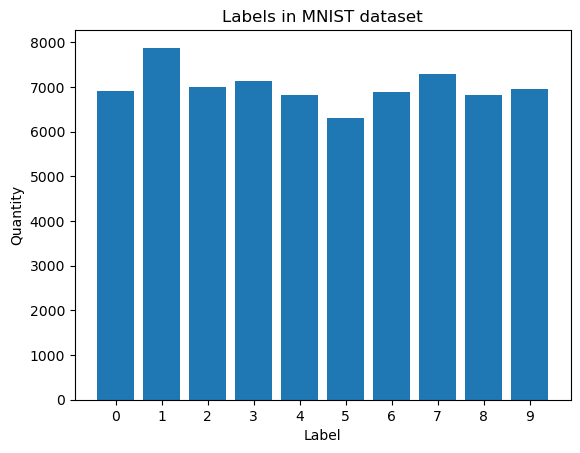

In [6]:
plt.bar(unq, cnt)
plt.xticks(unq)
plt.xlabel("Label")
plt.ylabel("Quantity")
plt.title("Labels in MNIST dataset")
plt.show()

## Undersampling & Oversampling

Here, undersampling and oversampling are applied to equalise the number of instances for each number.

In [7]:
ss_over  = {}
ss_under = {}

for u, c in zip(unq, cnt):
    if c < 7000:
        ss_over.update({u: 7000})
    elif c > 7000:
        ss_under.update({u: 7000})

In [8]:
ss_over

{'0': 7000, '2': 7000, '4': 7000, '5': 7000, '6': 7000, '8': 7000, '9': 7000}

In [9]:
ss_under

{'1': 7000, '3': 7000, '7': 7000}

In [10]:
ros = RandomOverSampler(sampling_strategy = ss_over)
rus = RandomUnderSampler(sampling_strategy = ss_under)

steps = [('o', ros), ('u', rus)]
pipeline = Pipeline(steps = steps)

x, y = pipeline.fit_resample(x.reshape(x.shape[0], -1), y)

In [11]:
unq, cnt = np.unique(y, return_counts = True)

for u, c in zip(unq, cnt):
    print(u, c)

0 7000
1 7000
2 7000
3 7000
4 7000
5 7000
6 7000
7 7000
8 7000
9 7000


Now, all numbers have the same number of instances.

Visualising just in case.

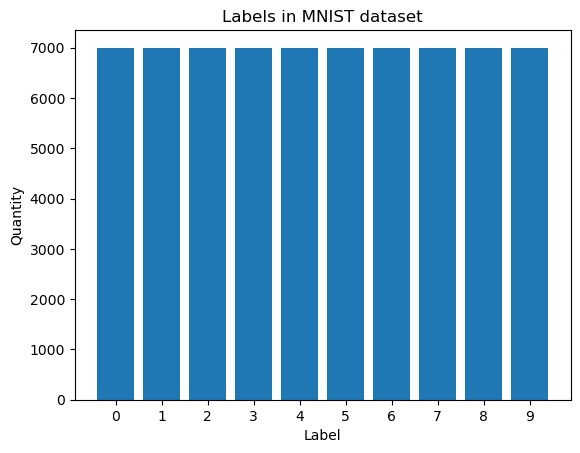

In [12]:
plt.bar(unq, cnt)
plt.xticks(unq)
plt.xlabel("Label")
plt.ylabel("Quantity")
plt.title("Labels in MNIST dataset")
plt.show()

Checking whether the combinations of *x* and *y* are correct.

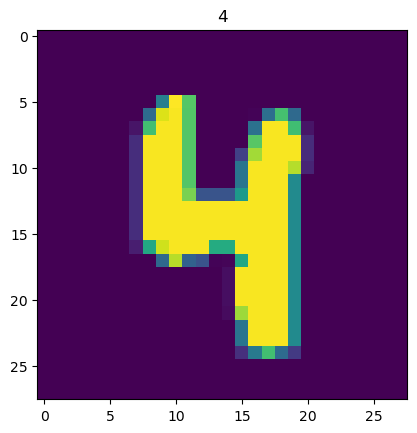

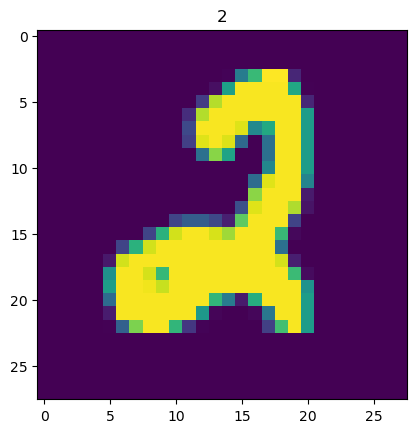

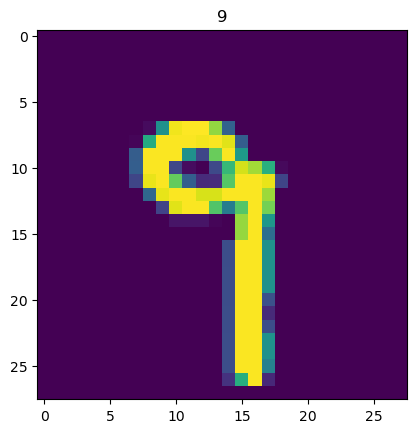

In [13]:
nums = np.random.randint(low = 0, high = 70000, size = (3))

for num in nums:
    plt.imshow(x[num].reshape(28, 28))
    plt.title(y[num])
    plt.show()

Seems fine.

## Train/Test Split

In [14]:
# Normsalisation
x = x / 255

# Reshaping x for CNN
x = x.reshape(-1, 28, 28, 1)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.15,
                                                    random_state = 0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(59500, 28, 28, 1)
(10500, 28, 28, 1)
(59500,)
(10500,)


In [16]:
# Turning the ys into categorical datasets
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

print(y_train.shape)
print(y_test.shape)

(59500, 10)
(10500, 10)


## Model Building

In [17]:
# Function for setting all seeds in each DL layer
def setting_seed(seed = 0):
    set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [18]:
model = Sequential()

setting_seed()
model.add(Conv2D(64, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
setting_seed()
model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(BatchNormalization())
model.add(Dropout(0.25))

setting_seed()
model.add(Conv2D(128, kernel_size = 5, padding = 'same', activation = 'relu'))
setting_seed()
model.add(MaxPooling2D(pool_size = (2, 2)))
# model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
setting_seed()
model.add(Dense(512, activation = 'relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.5))

setting_seed()
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer = "rmsprop", loss='categorical_crossentropy', metrics = ['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0

## Results

In [20]:
hist = model.fit(x_train, y_train,
                 epochs = 30, batch_size = 256, verbose = 1,
                 callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5)],
                 validation_split = 0.2)

Epoch 1/30


2023-12-03 09:43:47.976107: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


186/186 [==============================] - 112s 598ms/step - loss: 0.2797 - accuracy: 0.9104 - val_loss: 0.0571 - val_accuracy: 0.9813
Epoch 2/30
186/186 [==============================] - 110s 593ms/step - loss: 0.0633 - accuracy: 0.9804 - val_loss: 0.0376 - val_accuracy: 0.9876
Epoch 3/30
186/186 [==============================] - 112s 602ms/step - loss: 0.0454 - accuracy: 0.9853 - val_loss: 0.0306 - val_accuracy: 0.9905
Epoch 4/30
186/186 [==============================] - 114s 613ms/step - loss: 0.0345 - accuracy: 0.9890 - val_loss: 0.0292 - val_accuracy: 0.9910
Epoch 5/30
186/186 [==============================] - 114s 616ms/step - loss: 0.0289 - accuracy: 0.9908 - val_loss: 0.0307 - val_accuracy: 0.9892
Epoch 6/30
186/186 [==============================] - 110s 592ms/step - loss: 0.0235 - accuracy: 0.9928 - val_loss: 0.0291 - val_accuracy: 0.9908
Epoch 7/30
186/186 [==============================] - 111s 595ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0230 - val_accura

In [21]:
score = model.evaluate(x_test, y_test, verbose = 1)

print("loss:", score[0])
print("accuracy:", score[1])

329/329 [==============================] - 7s 22ms/step - loss: 0.0367 - accuracy: 0.9915
loss: 0.03669024258852005
accuracy: 0.991523802280426


The model appears to be able to predict images with high accuracy.

## EOF